# Задание 6

In [1]:
import numpy as np
from numpy.linalg import norm
import matplotlib.pyplot as plt
%matplotlib inline 

Начальные значения для модели:
```
    Rx_r = Радиус большого поля
    lambda0_block = Лямбда пуассона для блокираторов
    lambda0_I = Лямбда пуассона для объектов
    areaTotal = Площадь круга
    circle_radius = радиус блокаторов

    angl_phi = размер угла видимости у объектов
    ang_dist = расстояние линий угла (для отрисовки)

    Power = Мощность
```

In [2]:
Rx_r = 10
lambda0_block = 0.2
lambda0_I = 0.3
areaTotal = np.pi * Rx_r**2
circle_radius = 0.3

angl_phi = np.pi / 3
ang_dist = 1

Power = 1

две мат функции:
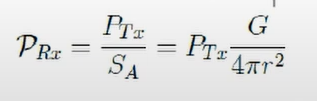
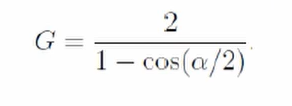


In [3]:
def G(phi):
    return 2/(1-np.cos(phi/2))

def PRx(power, Rx_Ii_d, phi):
    return power * G(phi) / (4*np.pi * Rx_Ii_d**2)

Отрисовка кругов блокаторов

In [4]:
def plot_circle(x,y,r):
    angels = np.linspace(0,2*np.pi,50)
    cirX = x+r*np.cos(angels)
    cirY = y+r*np.sin(angels)
    plt.plot(cirX, cirY, "r")

отрисовка углов видимости

In [5]:
def plot_angl(x1,y1, rand_angl, draw=True, ret=False):
    x2 = x1 + ang_dist * np.cos(rand_angl)
    y2 = y1 + ang_dist * np.sin(rand_angl)
    x3 = x1 + ang_dist * np.cos(rand_angl + angl_phi)
    y3 = y1 + ang_dist * np.sin(rand_angl + angl_phi)
    if draw:
        plt.plot([x1,x2], [y1,y2], "--m", )
        plt.plot([x1,x3], [y1,y3], "--m", )
        if ret:
            return (x2,y2), (x3,y3)
    else:
        return (x2,y2), (x3,y3)

Декартовы координаты в полярные и наоборот

In [6]:
def cart2pol(x, y):
    rho = np.sqrt(x**2 + y**2)
    phi = np.arctan2(y, x)
    return(rho, phi)

def pol2cart(rho, phi):
    x = rho * np.cos(phi)
    y = rho * np.sin(phi)
    return(x, y)

Генерация точек в круге пуассоновским распределением

In [7]:
def poisson_circle_points(l,area, r):
    numbPoints = np.random.poisson(l*areaTotal)
    phi=2*np.pi*np.random.uniform(0,1,numbPoints)
    rho=r*np.sqrt(np.random.uniform(0,1,numbPoints))

    X,Y = pol2cart(rho, phi)
    return X, Y

Расстояние 

In [8]:
def check_dist(a,b,c):
    ca = (c-a) / norm(c-a)
    ba = (b-a) / norm(b-a)
    cb = (c-b) / norm(c-b)
    ab = (a-b) / norm(a-b)
    
    if np.arccos(np.dot(ca,ba)) > 1:
        return norm(c-a)
    if np.arccos(np.dot(cb,ab)) > 1:
        return norm(c-b)
    return norm(np.cross(a-b, a-c)) / norm(b-a)

Проверка что блокатор не закрывает путь

In [9]:
def iscrossing(x_c:dict, y_c:dict, dot1:[tuple,dict], dot2:[tuple,dict]) -> bool:
    '''
    True - blocked
    False - NOT blocked
    '''
    for i in range(len(x_c)):
        if np.round(check_dist(np.array(dot1),np.array(dot2),np.array([x_c[i], y_c[i]])), 1) <= circle_radius:
                                        ## dot1[], dot2[], block_circle_center[]
            return True
    return False

Проверка что приемник в поле видимости объекта 

In [10]:
def check_visibility(dm: [tuple,dict], dfv: [tuple,dict], dsv: [tuple,dict]) -> bool:
    '''
    True - visible
    False - NOT visible
    '''
    
    rad1 = cart2pol(dfv[0]-dm[0], dfv[1]-dm[1])[1]
    rad2 = cart2pol(0-dm[0], 0-dm[1])[1]
    rad3 = cart2pol(dsv[0]-dm[0], dsv[1]-dm[1])[1]
    
    r1 = rad1 if rad1 >= 0 else rad1 + np.pi*2
    g1 = rad2 if rad2 >= 0 else rad2 + np.pi*2
    b1 = rad3 if rad3 >= 0 else rad3 + np.pi*2
    
    if g1 > r1 and g1 < b1:
        return True
    else:
        return False

Отрисовка модели

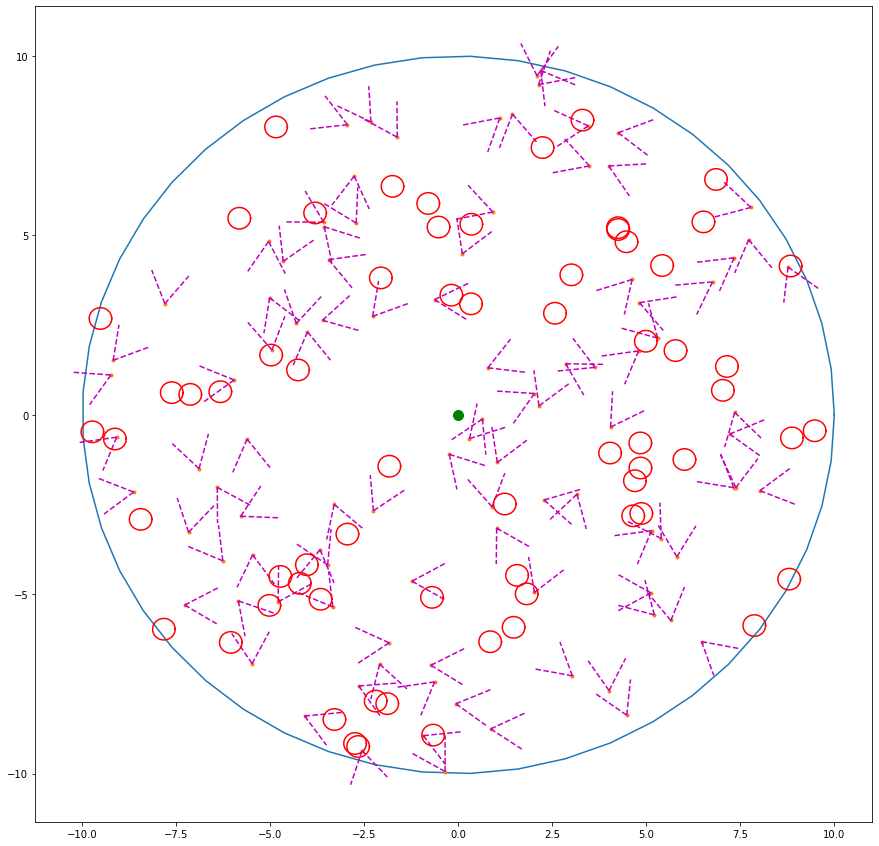

In [11]:
X_I,Y_I = poisson_circle_points(lambda0_I, areaTotal, Rx_r)
X_c, Y_c = poisson_circle_points(lambda0_block, areaTotal,Rx_r)

plt.figure(figsize=(15,15))

angels = np.linspace(0,2*np.pi,50)
cirX = Rx_r*np.cos(angels)
cirY = Rx_r*np.sin(angels)
plt.plot(cirX,cirY)

plt.plot(X_I, Y_I, ".")

Dots_F = []
Dots_S = []
for i,j in zip(X_I,Y_I):
    dot1,dot2 = plot_angl(i,j,np.random.uniform(0, 2*np.pi), ret=True)
    Dots_F.append(dot1)
    Dots_S.append(dot2)


plt.plot(0,0,'.g',markersize=20)

for i in range(len(X_c)):
    plot_circle(X_c[i], Y_c[i], circle_radius)

#### Проверка на блокировку

In [12]:
cnt = 0
for xi, yi in zip(X_I,Y_I):
    dot_i = (xi, yi)
    if iscrossing(X_c, Y_c, dot_i, (0,0)):
        cnt+=1
print("{} obj IS blocked out of {}".format(cnt, len(X_I)))

42 obj IS blocked out of 101


#### Проверка на видимость 

In [13]:
cnt = 0
for xi, yi, dot1, dot2 in zip(X_I,Y_I, Dots_F, Dots_S):
    dot_main = (xi, yi)
    if check_visibility(dot_main, dot1, dot2):
        cnt += 1
print("{} obg can see modtager out of {}".format(cnt, len(X_I)))

17 obg can see modtager out of 101


#### Проверка и на блокировку, и на видимость

In [14]:
cnt = 0
for xi, yi, dot1, dot2 in zip(X_I,Y_I, Dots_F, Dots_S):
        dot_main = (xi, yi)
        if not iscrossing(X_c, Y_c, dot_main, (0,0)) and check_visibility(dot_main, dot1, dot2):
            cnt+=1
print("{} obg CAN see modtager AND NOT blocked out of {}".format(cnt, len(X_I)))

8 obg CAN see modtager AND NOT blocked out of 101


# Построение графиков 

Я использовал по 10 значений изменяемого параметра + 100 реализаций модели для каждого из вариантов(1000 реализаций очень долго выполняется)

### График среднего значения интерференции от γ (размер угла направленности антенн)

In [19]:
# --CONFIGS--
Rx_r = 10
lambda0_block = 0.2
lambda0_I = 0.3
areaTotal = np.pi * Rx_r**2
circle_radius = 0.3
angl_phi = np.pi / 3
ang_dist = 1
Power = 1
# --CONFIGS--

phi_list = np.linspace(.01,np.pi-.01,10) # angel values (0,pi)
N = 100 # number of models 

Imean=[]
CNT_list = []

for p in phi_list:
    I_list = []
    models_cnt = []
    for _ in range(N):
        # Ctrating dots for blocking obj and for physycal obj
        X_I,Y_I = poisson_circle_points(lambda0_I, areaTotal,Rx_r)
        X_c, Y_c = poisson_circle_points(lambda0_block, areaTotal,Rx_r)
        
        # creating vectors for visibility angel 
        Dots_F = []
        Dots_S = []
        for i,j in zip(X_I,Y_I):
            dot1,dot2 = plot_angl(i, j, p, ret=True, draw=False)
            Dots_F.append(dot1)
            Dots_S.append(dot2)

        # checking if visible == True and isblocked == False 
        I_cnt = 0
        CNT = 0
        for xi, yi, dot1, dot2 in zip(X_I,Y_I, Dots_F, Dots_S):
            dot_main = (xi, yi)
            if not iscrossing(X_c, Y_c, dot_main, (0,0)) and check_visibility(dot_main, dot1, dot2):
                # correct obj counter 
                CNT+=1
                # counting dist from modtager to object
                distance = np.sqrt((xi)**2 + (yi)**2)
                # applying formula
                I_cnt += PRx(Power, distance, angl_phi)
        I_list.append(I_cnt)
        models_cnt.append(CNT)
    Imean.append(np.mean(I_list))
    CNT_list.append(np.mean(models_cnt))

Text(0, 0.5, 'I mean')

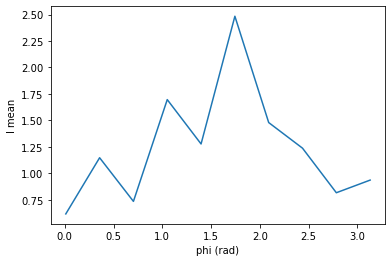

In [23]:
plt.plot(phi_list, Imean)
plt.xlabel("phi (rad)")
plt.ylabel("I mean")

### График среднего значения интерференции от интенсивности Пуассоновского поля источников интерферирующих устройств (lambda0_I)

In [24]:
# --CONFIGS--
Rx_r = 10
lambda0_block = 0.2
lambda0_I = 0.3
areaTotal = np.pi * Rx_r**2
circle_radius = 0.3
angl_phi = np.pi / 3
ang_dist = 1
Power = 1
# --CONFIGS--

lambda_I = np.linspace(.01, .5, 10) # poisson lambda for I objcts 
N = 100 # number of models 

Imean=[]
CNT_list = []

for lll in lambda_I:
    I_list = []
    models_cnt = []
    for _ in range(N):
        # Ctrating dots for blocking obj and for physycal obj
        X_I,Y_I = poisson_circle_points(lll, areaTotal,Rx_r)
        X_c, Y_c = poisson_circle_points(lambda0_block, areaTotal,Rx_r)
        
        # creating vectors for visibility angel 
        Dots_F = []
        Dots_S = []
        for i,j in zip(X_I,Y_I):
            dot1,dot2 = plot_angl(i, j, angl_phi, ret=True, draw=False)
            Dots_F.append(dot1)
            Dots_S.append(dot2)

        # checking if visible == True and isblocked == False 
        I_cnt = 0
        CNT = 0
        for xi, yi, dot1, dot2 in zip(X_I,Y_I, Dots_F, Dots_S):
            dot_main = (xi, yi)
            if not iscrossing(X_c, Y_c, dot_main, (0,0)) and check_visibility(dot_main, dot1, dot2):
                # correct obj counter 
                CNT+=1
                # counting dist from modtager to object
                distance = np.sqrt((xi)**2 + (yi)**2)
                # applying formula
                I_cnt += PRx(Power, distance, angl_phi)
        I_list.append(I_cnt)
        models_cnt.append(CNT)
    Imean.append(np.mean(I_list))
    CNT_list.append(np.mean(models_cnt))

Text(0, 0.5, 'I mean')

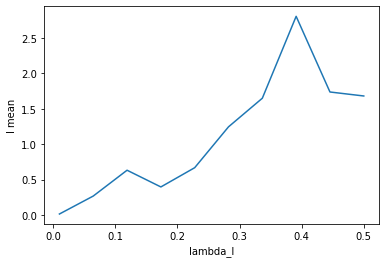

In [25]:
plt.plot(lambda_I, Imean)
plt.xlabel("lambda_I")
plt.ylabel("I mean")

### График среднего значения интерференции от интенсивности Пуассоновского поля блокирующих объектов (lambda0_block)

In [26]:
# --CONFIGS--
Rx_r = 10
lambda0_block = 0.2
lambda0_I = 0.3
areaTotal = np.pi * Rx_r**2
circle_radius = 0.3
angl_phi = np.pi / 3
ang_dist = 1
Power = 1
# --CONFIGS--

lambda_block = np.linspace(.01, .5, 10) # poisson lambda for blocking objcts
N = 100 # number of models 

Imean=[]
CNT_list = []

for lll in lambda_block:
    I_list = []
    models_cnt = []
    for _ in range(N):
        # Ctrating dots for blocking obj and for physycal obj
        X_I,Y_I = poisson_circle_points(lambda0_I, areaTotal,Rx_r)
        X_c, Y_c = poisson_circle_points(lll, areaTotal,Rx_r)
        
        # creating vectors for visibility angel 
        Dots_F = []
        Dots_S = []
        for i,j in zip(X_I,Y_I):
            dot1,dot2 = plot_angl(i, j, angl_phi, ret=True, draw=False)
            Dots_F.append(dot1)
            Dots_S.append(dot2)

        # checking if visible == True and isblocked == False 
        I_cnt = 0
        CNT = 0
        for xi, yi, dot1, dot2 in zip(X_I,Y_I, Dots_F, Dots_S):
            dot_main = (xi, yi)
            if not iscrossing(X_c, Y_c, dot_main, (0,0)) and check_visibility(dot_main, dot1, dot2):
                # correct obj counter 
                CNT+=1
                # counting dist from modtager to object
                distance = np.sqrt((xi)**2 + (yi)**2)
                # applying formula
                I_cnt += PRx(Power, distance, angl_phi)
        I_list.append(I_cnt)
        models_cnt.append(CNT)
    Imean.append(np.mean(I_list))
    CNT_list.append(np.mean(models_cnt))

Text(0, 0.5, 'I mean')

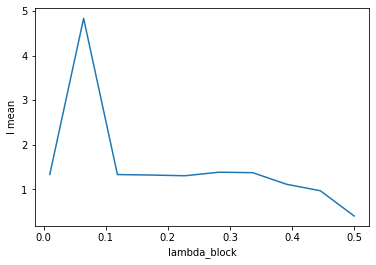

In [27]:
plt.plot(lambda_block, Imean)
plt.xlabel("lambda_block")
plt.ylabel("I mean")

#### График для самопроверки

Построил график зависимости от лямбды для блокарующих объектов (т.е. по сути их кол-во) от количества объектов которые не блокируются и ресивер попадает в их поле видимости.

Как можно заметить с увеличением кол-ва блокаторов(увеличением лямбды) уменьшается кол-во подходящих нам объектов удовлетворяющим обоим условиям (блокировка и видимости). Что логично, тк кол-во блокаторов увеличивается. А значит модель работает верно.

Text(0, 0.5, 'correct obj')

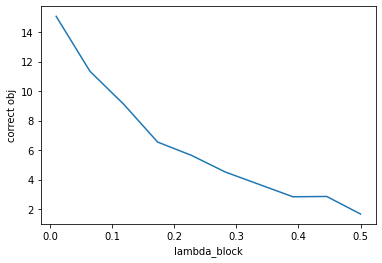

In [28]:
plt.plot(lambda_block, CNT_list)
plt.xlabel("lambda_block")
plt.ylabel("correct obj")